In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
digits = load_digits()
digits.data.shape

(1797, 64)

Vamos a ver algunos ejemplos de clustering con K-means.

En el primer ejemplo, vamos a intentar clusterizar un dataset de números. Este dataset consiste en 1797 imágenes (ejemplos/instancias) con 64 atributos (características/variables/*features*), donde cada una de esos 64 atributos es la intensidad de un pixel de una imagen en escala de grises de 8x8:

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_digits_classification_001.png">

# VC02 - Métodos de clustering basados en particiones

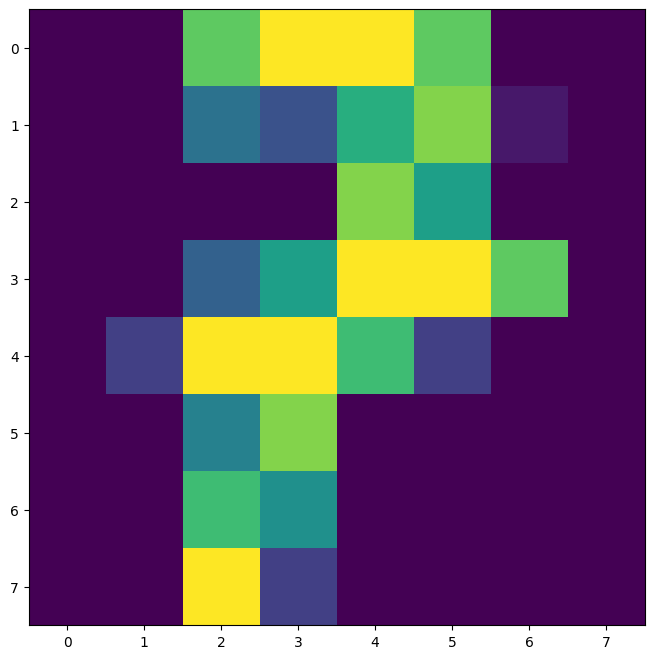

(<matplotlib.image.AxesImage at 0x7f276c81ae80>, None)

In [ ]:
plt.imshow(digits.data[1200].reshape((8,8))), plt.show()

In [3]:
# utilizamos k-means para hacer el clustering
#Le asignamos 10 al número de cluster porque sabemos que tenemos 10 diferentes digítos
#Por defecto este método uso Kmeans++ para asignar los centros: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
Kmeans=KMeans(n_clusters=10,random_state=0, n_init='auto')
clusters= Kmeans.fit_predict(digits.data)
clusters.shape 

#la variable clusters va hacer igual al número de elementos/muestras de mi dataset
#Los clusters son los elementos del dataset ya agrupados, gracias  Kmeans

#La dimension de los centros acá es (10,64)
#Los centros gracias a Kmeans ++ al prinicipio son elementos del dataset, y por eso la columna sería de 64
#Luego el centro de un cluster será una media de todos los elementos de un cluster


(1797,)

Fijaos que el resultado del clustering son 10 centroides (1 por cada cluster que le hemos pedido). Además, como hemos utilizado los pixeles "en crudo", estos centroides tienen las mismas dimensiones que las imágenes de entrada (`10x64`) y representan al "típico" número de cada cluster. Vamos a visualizarlos:

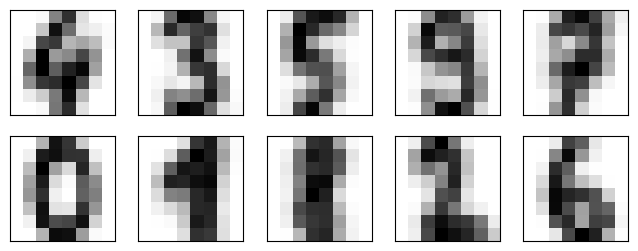

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
#Extraer los centros de cada cluster y se hace un reshape de 8x8 para poder imprimir las imaganes 
centers = Kmeans.cluster_centers_.reshape(10, 8, 8)

#Plotear los centros de cada cluster
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

#Los centros ploteados representan a los dígitos que deseamos agrupar, pero no se logran ver muy definidos no solo por los pocos pixeles
#sino también es porque los pixeles de cada centro de cada cluster es una media de todos los elementos que lo conforma.

Tal y como podemos observar, el K-means es capaz de encontrar los clusters cuyos centros son los números del 0 al 9, a excepción del 1 y el 8 que los confunde un poco.

Vamos a calcular algunas métricas intrínsecas y extrínsecas de las vistas en clase para comprobar cómo ha ido el clustering cuantitativamente.

In [4]:
from sklearn.metrics import cluster

In [5]:
print('Completness score =', cluster.completeness_score(digits.target, clusters))
print('Homogeneidad =', cluster.homogeneity_score(digits.target, clusters))
print('Información mutua (ajustada) =', cluster.adjusted_mutual_info_score(digits.target, clusters))

Completness score = 0.7421559553417136
Homogeneidad = 0.7346773687483245
Información mutua (ajustada) = 0.7357654001724041


Ya que tenemos las etiquetas reales, vamos a calcular el accuracy. Para ello, vamos a usar la función `accuracy_score` disponible en  `sklearn.metrics`.

Daos cuenta de que como hemos hablado en las clases, el k-means hace agrupamientos pero no tiene ni idea de a qué *clase* pertenece cada uno. Simplemente agrupa las imágenes por **similitud**, de forma parecida a lo que haría un *k nearest neighbours (kNN)* o algoritmo de vecinos cercanos.

Por ello, lo primero que vamos a hacer es asignarle a cada cluster la etiqueta de acuerdo a la moda de sus elementos. Es decir, nos fijaremos en qué elemento se repite más en cada cluster, y ese será la etiqueta.

In [6]:
import numpy as np
from scipy.stats import mode

#un array de 0 con la misma dimensión de clusters
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

<ipython-input-6-6ad35ad119db>:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(digits.target[mask])[0]


Y ahora ya podemos calcular el accuracy:

In [7]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7885364496382861

Y también la matriz de confusión:

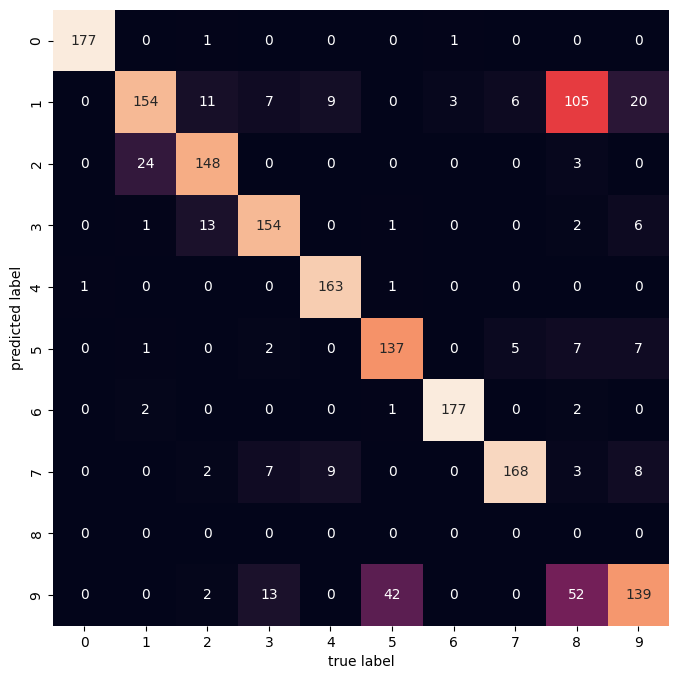

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Fijaos que hemos conseguido clasificar correctamente el 80% de nuestras imágenes con un simple K-means sin siquiera preprocesar los datos. Como hemos comprobado antes al plotear las imágenes, el algoritmo se confunde sobretodo con el 1 y el 8.

¿Y si realizásemos algún tipo de preprocesamiento que nos permitiese mejorar los resultados?

Vamos a ver qué pasaría si usásemos una técnica de reducción de dimensionalidad conocida como t-SNE (https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm):

In [9]:
from sklearn.manifold import TSNE

<ipython-input-12-d999eb66b98e>:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(digits.target[mask])[0]


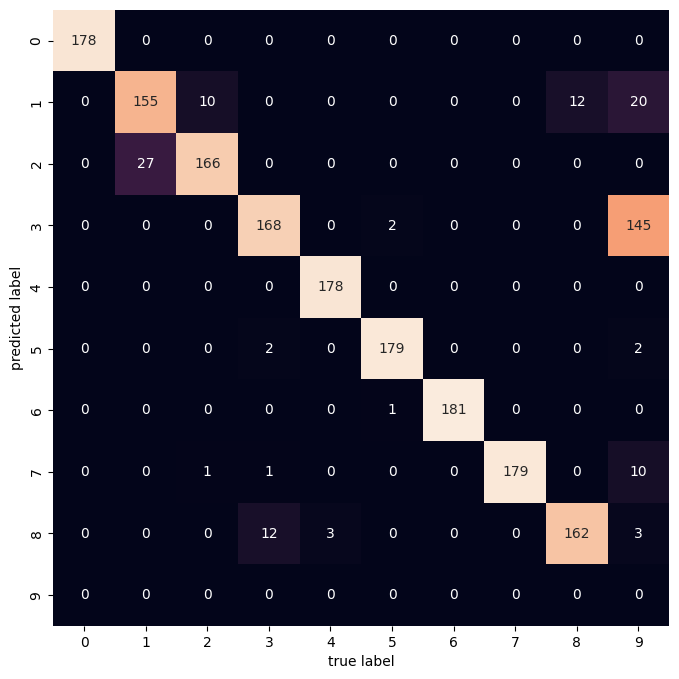

In [12]:
# Utilizamos t-SNE para proyectar los datos en otro espacio de 2 dimensiones
# Este paso tarda unos segundos, no os impacientéis :)
#Prepocesado de los datos
tsne = TSNE(n_components=2, init='random', random_state=42)
#Variables proyectadas en 2 dimensiones de 64 paso a 2 dimensiones
digits_proj = tsne.fit_transform(digits.data)

#Luego de realizar este cambio de dimensiones cuales son las dimensiones de mis centros?
#En este ejemplo sería de (1,2) y y los diez centros tienen dimensión (10,2)



# Realizamos el clustering

kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(digits_proj)

# Asignamos las etiquetas de acuerdo a la moda
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Calculamos el accuracy
accuracy_score(digits.target, labels)

# Mostramos la matriz de confusión
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [11]:
accuracy_score(digits.target, labels)

0.9415692821368948

¿Qué os parece? Daos cuenta de la importancia de preprocesar los datos de una forma adecuada. Con esta simple decisión hemos mejorado en un 13% la precisión de nuestro algoritmo.

¡Que no se os olvide! ;)

El segundo ejemplo que vamos a ver trata sobre compresión de imágenes. Sí, aunque parezca mentira, se pueden usar técnicas de clustering para ello.

Simplemente reducimos el número total de colores utilizados para representar la imagen, y de esta forma permitimos que se necesiten menos memoria (bits) para su almacenaje.

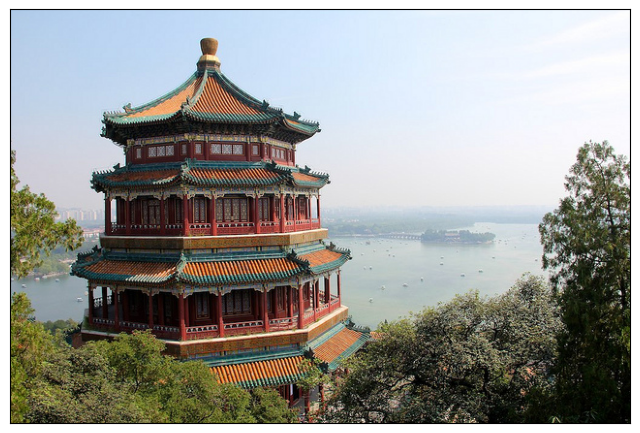

In [13]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

Recordad que las imagenes se representan como matrices de `(alto, ancho, canales)`, donde los valores de los canales son rojo/verde/azul y varían de 0 a 255.

In [14]:
china.shape

(427, 640, 3)

Sin embargo, podemos ver este dataset como una nube de puntos tridimensional, donde cada pixel es una instancia.

Vamos a normalizar los valores entre 0 y 1 y a convertirlos en `[n_instancias, 3]`.

In [15]:
china.max()

255

In [16]:
# normalizamos la imagen para que tenga valores entre 0 y 1
data = china / 255
#hacemos un flatten de mi imagen
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Ahora vamos a visualizar los pixels:

In [17]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

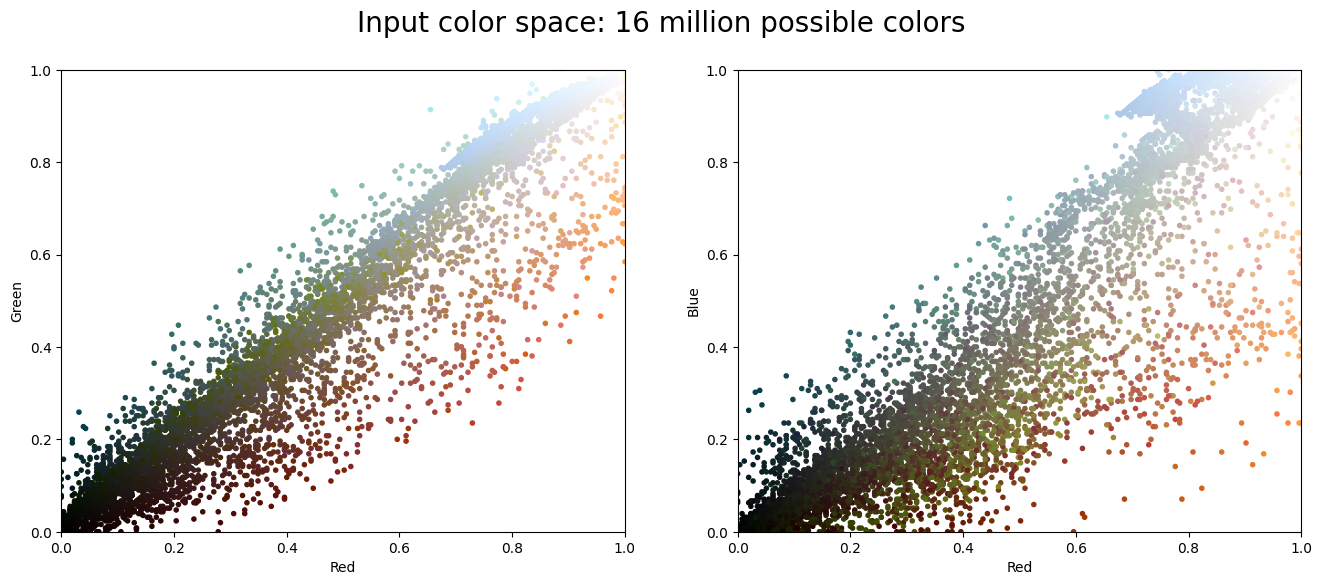

In [18]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Vamos ahora a reducir de 16 millones de colores a 16.

Como se trata de un dataset grande, vamos a usar una variación del k-means llamada mini-batch k-Means, que funciona exactamente igual que el k-means pero con mini-batches.



(273280, 3)


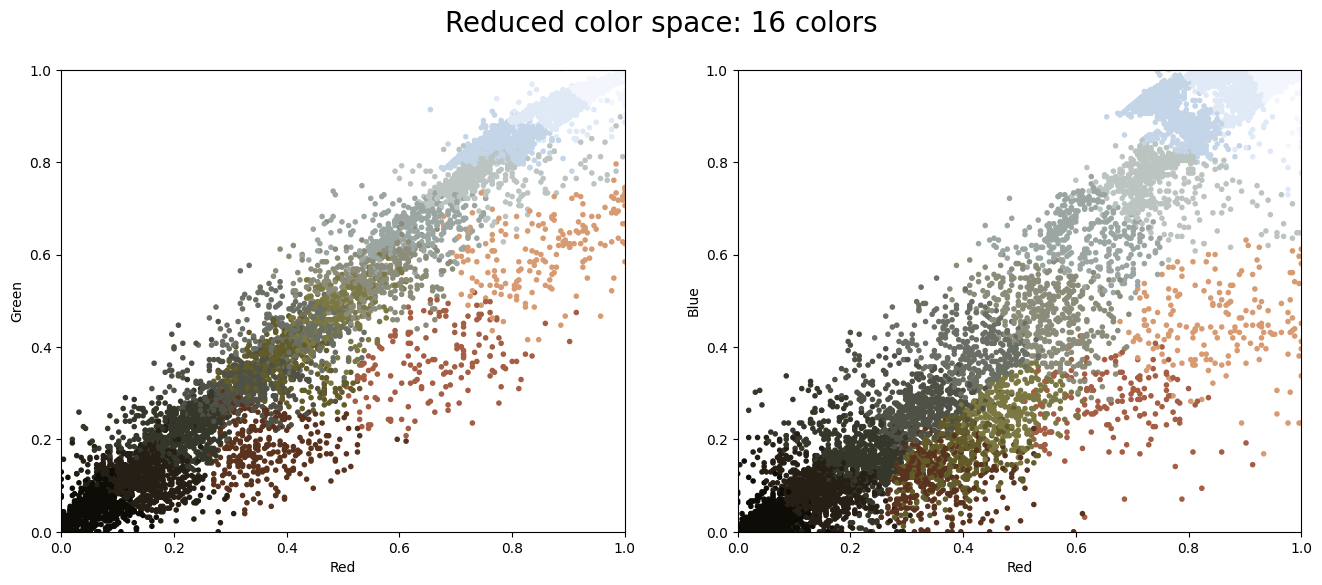

In [19]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
print(new_colors.shape)
plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")

Perfecto. Acabamos de conseguir reducir el número de colores a 16, como podéis observar.

Vamos a transformar la imagen:

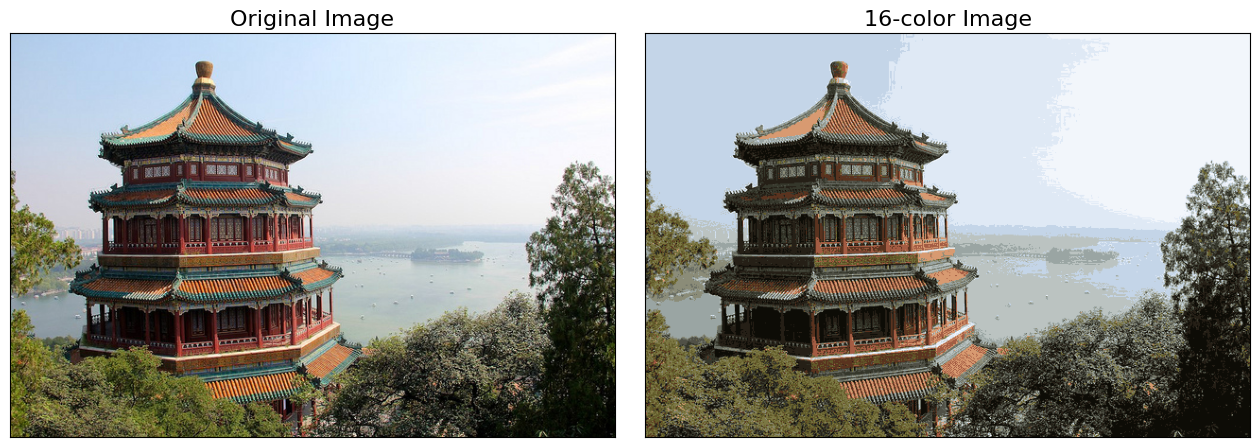

In [20]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

In [21]:
#Vamos a calcular el tamaño de cada imagen
# Ocupa aproximadamente 820 Kb (819976 bytes)
import sys
sys.getsizeof(china)

819984

In [22]:
sys.getsizeof(china_recolored)
# 136 bytes, no llega a 1Kb

144

Es indiscutible que se pierde calidad, pero pensad que acabamos de conseguir comprimir la imagen con un factor de más o menos 1 millón!

La fuente de estos ejemplos, para quien quiera consultarla: 

*   https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
*   https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html
*   https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
